In [0]:
from sympy.abc import a, c, x, y, z
from sympy.core.numbers import Zero
import sympy as sp
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt

In [0]:
# OPERATIONAL CONSTANTS
class Constants:
  LINEAR = "linear"
  POLY_QUADRATIC = "quadratic"
  POLY_CUBIC = "cubic"
  STEP_CONSTANT = "jump"
  STEP_VARIABLE = "kink"
  INTERACTION_TWO_WAY = "interaction_two"
  INTERACTION_THREE_WAY = "interaction_three"

  COVARIATE_SYMBOLS_KEY = "covariates"
  EXPRESSION_KEY = "expr"

  SUBFUNCTION_FORMS = {
    LINEAR: {
        COVARIATE_SYMBOLS_KEY: [x],
        EXPRESSION_KEY: c*x
    },
    POLY_QUADRATIC: {
        COVARIATE_SYMBOLS_KEY: [x],
        EXPRESSION_KEY: c*(x**2)
    },
    POLY_CUBIC: {
        COVARIATE_SYMBOLS_KEY: [x],
        EXPRESSION_KEY: c*(x**3)
    },
    STEP_CONSTANT: {
        COVARIATE_SYMBOLS_KEY: [x],
        EXPRESSION_KEY: sp.Piecewise((0, x < a), (c, True))
    },
    STEP_VARIABLE: {
        COVARIATE_SYMBOLS_KEY: [x],
        EXPRESSION_KEY: sp.Piecewise((0, x < a), (c*x, True))
    },
    INTERACTION_TWO_WAY: {
        COVARIATE_SYMBOLS_KEY: [x, y],
        EXPRESSION_KEY: c*x*y
    },
    INTERACTION_THREE_WAY: {
        COVARIATE_SYMBOLS_KEY: [x, y, z],
        EXPRESSION_KEY: c*x*y*z
    },
  }

  SUBFUNCTION_CONSTANT_SYMBOLS = {a, c}

  TREATMENT_EFFECT_SYMBOL = sp.symbols("T")
  OUTCOME_NOISE_SYMBOL = sp.symbols("NOISE")

In [0]:
class Parameters:
  ### CONFOUNDER SETTINGS ##

  # Probability that a covariate is a potential confounder
  # (affecting one or both of treatment and outcome)
  # Lower values reduce the number of covariates which are predicitive
  # of treatment/outcome. This makes modelling harder given need
  # for variable selection.
  # TODO: consider differential selection of different covariate types.
  POTENTIAL_CONFOUNDER_SELECTION_PROBABILITY = 0.6

  # Probability that a covariate in the true space
  # will appear in both the outcome and treatment functions.
  # This is a soft target, with some room for variance.
  ACTUAL_CONFOUNDER_ALIGNMENT = 0.5

  ### SHARED TREAT/OUTCOME FUNCTION SETTINGS ###

  # Probabilities which govern the probability with which
  # covariates appear in the treatment mechanism in different
  # forms.
  TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY = {
    Constants.LINEAR: 0.5,
    Constants.POLY_QUADRATIC: 0.25,
    Constants.POLY_CUBIC: 0.05,
    Constants.STEP_CONSTANT: 0.01,
    Constants.STEP_VARIABLE: 0,
    Constants.INTERACTION_TWO_WAY: 0.7,
    Constants.INTERACTION_THREE_WAY: 0.02
  }

  OUTCOME_MECHANISM_COVARIATE_SELECTION_PROBABILITY = {
    Constants.LINEAR: 0.5,
    Constants.POLY_QUADRATIC: 0.2,
    Constants.POLY_CUBIC: 0.07,
    Constants.STEP_CONSTANT: 0.05,
    Constants.STEP_VARIABLE: 0,
    Constants.INTERACTION_TWO_WAY: 0.11,
    Constants.INTERACTION_THREE_WAY: 0.04
  }
  
  @staticmethod
  def sample_subfunction_constants(size=1):
    # DF for the T-distribution over subfunction constants.
    SUBFUNCTION_CONSTANT_TAIL_THICKNESS = 3
    return np.round(np.random.standard_t(
               SUBFUNCTION_CONSTANT_TAIL_THICKNESS, size=size), 3)

  ### TREATMENT FUNCTION PARAMS ###

  # propensity score settings
  MIN_PROPENSITY_SCORE = 0.05
  MAX_PROPENSITY_SCORE = 0.95
  TARGET_PROPENSITY_SCORE = 0.65
  TARGET_MIN_LOGIT = sp.solve((np.e**x/(1+np.e**x)) - MIN_PROPENSITY_SCORE, x)[0]
  TARGET_MAX_LOGIT = sp.solve((np.e**x/(1+np.e**x)) - MAX_PROPENSITY_SCORE, x)[0]
  TARGET_MEAN_LOGIT = sp.solve((np.e**x/(1+np.e**x)) - TARGET_PROPENSITY_SCORE, x)[0]

  ### OUTCOME FUNCTION PARAMS ###
  
  @staticmethod
  def sample_outcome_noise(size=1):
    # DF for the T-distribution over outcome noise.
    OUTCOME_NOISE_TAIL_THICKNESS = 3
    return np.round(np.random.standard_t(
              OUTCOME_NOISE_TAIL_THICKNESS, size=size), 3)
    
  # Treatment Effect

  # Marginal probability that there is an interaction between the
  # base treatment effect and each subfunction in the outcome function.
  TREATMENT_EFFECT_HETEROGENEITY = 0.3

  @staticmethod
  def sample_treatment_effect(size=1):
    # DF for the T-distribution over treatment effects.
    TREATMENT_EFFECT_TAIL_THICKNESS = 3
    return np.round(np.random.standard_t(
              TREATMENT_EFFECT_TAIL_THICKNESS, size=size), 3)

  # Marginal probability of observing any given row of the dataset.
  # Used to reduce the overall number of observations if desired.
  OBSERVATION_PROBABILITY = 1

In [0]:
# Utility functions

def select_given_probability_distribution(full_list, selection_probabilities):
  full_list = np.array(full_list)
  
  flat = len(full_list.shape) == 1
  if flat:
    full_list = full_list.reshape((-1, 1))

  selections = np.random.uniform(size=full_list.shape[0]) < selection_probabilities
  selected = full_list[selections, :]
  if flat:
    selected = selected.flatten()
  return selected, selections

def evaluate_expression(expression, data):
  free_symbols = list(expression.free_symbols)
  func = np.vectorize(sp.lambdify(
      free_symbols,
      expression,
      "numpy",
      dummify=False))
  
  covar_data = [data[[str(symbol)]].to_numpy() for symbol in free_symbols]
  return func(*covar_data).flatten()

@np.vectorize
def initialize_expression_constants(expression):
  constants_to_initialize = \
    Constants.SUBFUNCTION_CONSTANT_SYMBOLS.intersection(expression.free_symbols)

  return expression.subs(zip(constants_to_initialize,
                             Parameters.sample_subfunction_constants(
                                 size=len(constants_to_initialize))))

In [5]:
def build_data_frame(covar_data, covar_names):
  n_observations = covar_data.shape[0]
  
  # Build DF
  data = pd.DataFrame(
      data=covar_data,
      columns=covar_names,
      index=np.arange(n_observations))

  # Sample and add noise column
  noise_samples = Parameters.sample_outcome_noise(size=n_observations)
  data[str(Constants.OUTCOME_NOISE_SYMBOL)] = noise_samples

  # Sample observations to reduce observation count if desired.
  data = data.sample(frac=Parameters.OBSERVATION_PROBABILITY)

  # generate symbols for all covariates
  covar_symbols = np.array(sp.symbols(covar_names))

  return data, covar_symbols

N_COVARS = 20
N_OBSERVATIONS = 1000

# Generate random covariates and name sequentially
X = np.random.uniform(size=(N_OBSERVATIONS, N_COVARS))
COVAR_NAMES = np.array([f"X{i}" for i in range(N_COVARS)])

# Build data frame
data, covar_symbols = build_data_frame(X, list(COVAR_NAMES))

print(data.shape)
data.head()

(1000, 21)


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,NOISE
240,0.440148,0.170260,0.399614,0.768387,0.408259,0.799566,0.553463,0.239189,0.318775,0.411255,0.231012,0.012998,0.694210,0.012542,0.595709,0.876009,0.265789,0.062159,0.929797,0.610101,-0.137
644,0.331978,0.473813,0.314697,0.692536,0.789322,0.587039,0.064299,0.736767,0.368566,0.373258,0.148944,0.541913,0.935841,0.302158,0.026282,0.993412,0.423610,0.205694,0.513050,0.316144,2.135
394,0.450361,0.763392,0.625457,0.981302,0.341181,0.404078,0.453400,0.639231,0.687692,0.583395,0.272192,0.857505,0.629078,0.531686,0.631937,0.326271,0.102607,0.201490,0.773238,0.828197,1.479
288,0.529240,0.994050,0.817920,0.197531,0.492905,0.655323,0.357639,0.544694,0.062129,0.195737,0.857002,0.198032,0.841540,0.403730,0.983982,0.578316,0.125725,0.506940,0.386986,0.326704,-1.798
381,0.444219,0.026177,0.516176,0.267549,0.416148,0.161418,0.100017,0.113638,0.245933,0.222225,0.119491,0.104972,0.089057,0.976567,0.083897,0.661615,0.402827,0.716543,0.826170,0.649675,2.013


### 1) Select Potential Confounders

In [6]:
potential_confounder_symbols, potential_confounder_selections = select_given_probability_distribution(
    full_list=covar_symbols,
    selection_probabilities=Parameters.POTENTIAL_CONFOUNDER_SELECTION_PROBABILITY)

potential_confounder_symbols

array([X1, X3, X4, X6, X7, X8, X13, X15, X16, X17, X19], dtype=object)

### 2) Create new covariate spaces for Treat/Outcome

This stage determines the linearity of the functions

In [0]:
def generate_transformed_covariate_space(covariate_symbols, subfunction_form_probabilities):
  subfunctions = []
  for subfunction_form_name, subfunction_form in Constants.SUBFUNCTION_FORMS.items():
    subfunc_expression = subfunction_form[Constants.EXPRESSION_KEY]
    subfunc_covariate_symbols = subfunction_form[Constants.COVARIATE_SYMBOLS_KEY]

    # All possible combinations of covariates for the given subfunc.
    covariate_combinations = np.array(list(combinations(covariate_symbols,
                                        len(subfunc_covariate_symbols))))
  
    selected_covar_combinations, _ = select_given_probability_distribution(
      full_list=covariate_combinations,
      selection_probabilities=subfunction_form_probabilities[subfunction_form_name])
    
    
    subfunctions.extend([ 
                          subfunc_expression.subs(
                              zip(subfunc_covariate_symbols, covar_comb))
                          for covar_comb in selected_covar_combinations
                        ])

  
  return subfunctions

In [0]:
def generate_aligned_treatment_and_outcome_covariates(covariate_symbols):
  true_outcome_covariates = generate_transformed_covariate_space(
      covariate_symbols,
      Parameters.OUTCOME_MECHANISM_COVARIATE_SELECTION_PROBABILITY)

  true_treatment_covariates = generate_transformed_covariate_space(
      covariate_symbols,
      Parameters.TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY)

  # Unique set of all covariates
  true_covariates = np.array(list(set(true_treatment_covariates + true_outcome_covariates)))
  
  # Select overlapping covariates (confounders) given alignment
  # parameter.
  shared_confounders, _ = select_given_probability_distribution(
      true_covariates,
      selection_probabilities=Parameters.ACTUAL_CONFOUNDER_ALIGNMENT)
  shared_confounders = set(shared_confounders)

  # Union the true confounders into the original covariate selections.
  true_outcome_covariates = list(shared_confounders.union(true_outcome_covariates))
  true_treatment_covariates = list(shared_confounders.union(true_treatment_covariates))

  return true_outcome_covariates, true_treatment_covariates

true_outcome_covariates, true_treatment_covariates = \
  generate_aligned_treatment_and_outcome_covariates(potential_confounder_symbols)

### 3) Create Treatment Function

In [0]:
def generate_treatment_function(treatment_subfunctions, data):
  # TODO: consider recursively applying the covariate transformation
  # to produce "deep" functions. Probability overkill.

  # TODO: enable overlap adjustment

  # Randomly initialize subfunction constants
  initialized_subfunctions = initialize_expression_constants(treatment_subfunctions)

  # Build base treatment logit function. Additive combination of the true covariates.
  # TODO: add non-linear activation function
  base_treatment_logit_expression = np.sum(initialized_subfunctions)

  # Sample data to evaluate distribution.
  sampled_data = data.sample(frac=0.25)

  # Adjust logit
  logit_values = evaluate_expression(base_treatment_logit_expression, sampled_data)
  max_logit = np.max(logit_values)
  min_logit = np.min(logit_values)
  mean_logit = np.mean(logit_values)

  # Rescale to meet min/max constraints and target propensity.
  # First, construct function to rescale between 0 and 1
  normalized_logit_expr = (x - min_logit)/(max_logit - min_logit)
  
  # Second, construct function to rescale to target interval
  constrained_logit_expr = Parameters.TARGET_MIN_LOGIT + \
    (x*(Parameters.TARGET_MAX_LOGIT - Parameters.TARGET_MIN_LOGIT))

  rescaling_expr = constrained_logit_expr.subs(x, normalized_logit_expr)
  rescaled_logit_mean = rescaling_expr.evalf(subs={x: mean_logit})

  # Third, construct function to apply offset for targeted propensity.
  # This requires the rescaled mean found above.
  target_propensity_adjustment = Parameters.TARGET_MEAN_LOGIT - rescaled_logit_mean
  targeted_logit_expr = rescaling_expr + target_propensity_adjustment

  # Apply max/min truncation to account for adjustment shift.
  max_min_capped_targeted_logit = sp.functions.Max(
      sp.functions.Min(targeted_logit_expr, Parameters.TARGET_MAX_LOGIT),
      Parameters.TARGET_MIN_LOGIT)
  
  # Finally, construct the full function expression.
  treatment_logit_expr = max_min_capped_targeted_logit.subs(
      x, base_treatment_logit_expression)
  exponentiated_logit = sp.functions.exp(treatment_logit_expr)
  logistic_function = exponentiated_logit/(1 + exponentiated_logit)

  return logistic_function

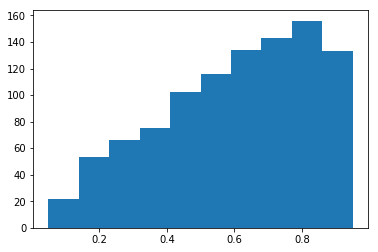

In [10]:
treatment_function = generate_treatment_function(true_treatment_covariates, data)
vals = evaluate_expression(treatment_function, data)
plt.hist(vals)

plt.show()

### 4) Create outcome function

In [0]:
def generate_treatment_effect_subfunction(outcome_subfunctions, data):
  base_treatment_effect = Parameters.sample_treatment_effect()[0]
  
  # Sample outcome subfunctions to interact with Treatment effect.
  selected_interaction_terms, _ = select_given_probability_distribution(
      full_list=outcome_subfunctions,
      selection_probabilities=Parameters.TREATMENT_EFFECT_HETEROGENEITY)
  
  # Build multiplier
  treatment_effect_multiplier_expr = np.sum(selected_interaction_terms)

  # Normalize multiplier size but not location. This keeps the size
  # of the effect bounded but doesn't center the effect for different units
  # at 0.
  sampled_data = data.sample(frac=0.25)
  treatment_effect_multiplier_values = evaluate_expression(treatment_effect_multiplier_expr, sampled_data)
  multiplier_std = np.std(treatment_effect_multiplier_values)
  multiplier_mean = np.mean(treatment_effect_multiplier_values)
  normalized_treatment_effect_multiplier_expr = (treatment_effect_multiplier_expr - multiplier_mean)/multiplier_std

  treatment_effect_subfunction = base_treatment_effect*(1+normalized_treatment_effect_multiplier_expr)

  return treatment_effect_subfunction

def generate_outcome_function(outcome_subfunctions, data):
  # TODO: consider recursively applying the covariate transformation
  # to produce "deep" functions. Probability overkill.

  # Randomly initialize subfunction constants
  initialized_subfunctions = initialize_expression_constants(outcome_subfunctions)

  # Build base outcome function. Additive combination of the true covariates.
  # TODO: add non-linear activation function
  base_outcome_expression = np.sum(initialized_subfunctions)

  # Sample data to evaluate distribution.
  sampled_data = data.sample(frac=0.25)

  # Normalized outcome values to have approximate mean=0 and std=1.
  # This prevents situations where large outcome values drown out
  # the treatment effect or the treatment effect dominates small average outcomes.
  outcome_values = evaluate_expression(base_outcome_expression, sampled_data)
  outcome_mean = np.mean(outcome_values)
  outcome_std = np.std(outcome_values)

  # This is only an approximate normalization. It will shift the mean to zero
  # but the exact effect on std will depend on the distribution.
  normalized_outcome_expression = (base_outcome_expression - outcome_mean)/outcome_std

  # Create the treatment effect subfunction.
  treatment_effect_expression = generate_treatment_effect_subfunction(
      initialized_subfunctions, data)
  
  response_surface_expression = normalized_outcome_expression + \
    Constants.TREATMENT_EFFECT_SYMBOL*treatment_effect_expression + \
    Constants.OUTCOME_NOISE_SYMBOL
  
  return response_surface_expression

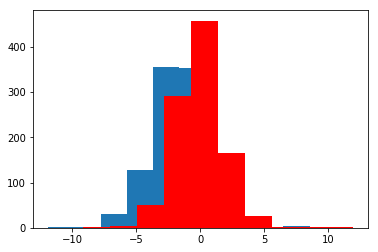

In [14]:
outcome_function = generate_outcome_function(true_outcome_covariates, data)

vals = evaluate_expression(outcome_function.subs(Constants.TREATMENT_EFFECT_SYMBOL, 1), data)
plt.hist(vals)
vals = evaluate_expression(outcome_function.subs(Constants.TREATMENT_EFFECT_SYMBOL, 0), data)
plt.hist(vals, color="r")

plt.show()

In [15]:
def simulate_treatment_and_potential_outcomes(treatment_function, outcome_function, data):
  n_observations = data.shape[0]

  simulated_data = data.copy()

  propensity_scores = evaluate_expression(treatment_function, data)
  T = (np.random.uniform(size=n_observations) < propensity_scores).astype(int)

  simulated_data["T"] = T

  Y0 = evaluate_expression(
      outcome_function.subs(Constants.TREATMENT_EFFECT_SYMBOL, 0), data)
  Y1 = evaluate_expression(
      outcome_function.subs(Constants.TREATMENT_EFFECT_SYMBOL, 1), data)
  simulated_data["Y0"] = Y0
  simulated_data["Y1"] = Y1
  
  Y = (T*Y1) + ((1-T)*Y0)
  simulated_data["Y"] = Y

  treatment_effect = Y1 - Y0
  simulated_data["treatment_effect"] = treatment_effect

  return simulated_data

simulated_data = simulate_treatment_and_potential_outcomes(treatment_function, outcome_function, data)
simulated_data.head(n=10)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,NOISE,T,Y0,Y1,Y,treatment_effect
240,0.440148,0.170260,0.399614,0.768387,0.408259,0.799566,0.553463,0.239189,0.318775,0.411255,0.231012,0.012998,0.694210,0.012542,0.595709,0.876009,0.265789,0.062159,0.929797,0.610101,-0.137,1,-0.997102,-2.651038,-2.651038,-1.653936
644,0.331978,0.473813,0.314697,0.692536,0.789322,0.587039,0.064299,0.736767,0.368566,0.373258,0.148944,0.541913,0.935841,0.302158,0.026282,0.993412,0.423610,0.205694,0.513050,0.316144,2.135,0,3.102370,1.535330,3.102370,-1.567040
394,0.450361,0.763392,0.625457,0.981302,0.341181,0.404078,0.453400,0.639231,0.687692,0.583395,0.272192,0.857505,0.629078,0.531686,0.631937,0.326271,0.102607,0.201490,0.773238,0.828197,1.479,1,2.188838,1.512735,1.512735,-0.676104
288,0.529240,0.994050,0.817920,0.197531,0.492905,0.655323,0.357639,0.544694,0.062129,0.195737,0.857002,0.198032,0.841540,0.403730,0.983982,0.578316,0.125725,0.506940,0.386986,0.326704,-1.798,1,-1.574827,-2.193857,-2.193857,-0.619029
381,0.444219,0.026177,0.516176,0.267549,0.416148,0.161418,0.100017,0.113638,0.245933,0.222225,0.119491,0.104972,0.089057,0.976567,0.083897,0.661615,0.402827,0.716543,0.826170,0.649675,2.013,1,1.491705,-1.541192,-1.541192,-3.032897
96,0.111794,0.689892,0.195804,0.470815,0.291251,0.452225,0.952093,0.469988,0.696889,0.460999,0.856566,0.230369,0.649433,0.314804,0.800176,0.626797,0.852888,0.532022,0.243244,0.773336,-1.983,1,-2.603340,-5.926348,-5.926348,-3.323007
52,0.341273,0.104198,0.778552,0.529267,0.762578,0.010931,0.954223,0.494455,0.983973,0.856423,0.376340,0.309842,0.975887,0.330003,0.129133,0.832919,0.622823,0.875483,0.785582,0.686621,-1.026,1,-1.163396,-5.762717,-5.762717,-4.599321
938,0.327672,0.913267,0.081235,0.010802,0.716633,0.876903,0.435505,0.926140,0.801840,0.751622,0.748553,0.377965,0.485309,0.122880,0.519802,0.959847,0.403948,0.142587,0.649424,0.426002,0.258,0,1.734281,-1.324521,1.734281,-3.058802
82,0.511831,0.966491,0.268510,0.971209,0.544634,0.361532,0.901692,0.755599,0.817580,0.091122,0.564850,0.591127,0.710969,0.010957,0.409863,0.667689,0.424957,0.575193,0.935210,0.283855,-0.848,1,1.475929,-1.352209,-1.352209,-2.828138
696,0.792369,0.224002,0.384550,0.583530,0.897605,0.814141,0.840800,0.833617,0.509018,0.667197,0.555571,0.603072,0.318650,0.272166,0.305021,0.756964,0.824522,0.775143,0.250810,0.691357,-1.945,0,-1.684129,-4.660488,-1.684129,-2.976359
